# Phase 2 - Transfer Learning on CIFAR10

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time
import os
import copy

import matplotlib.pyplot as plt
import numpy as np

## 1) Download and Load CIFAR10

You can find CIFAR10 in ```torchvision.datasets.CIFAR10()``` or see [here](https://pytorch.org/vision/0.15/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10). Please Download the dataset and use Dataloaders to load it.

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

train_set = datasets.CIFAR10(root = './data', train = True,
                        transform = transform, download = True)

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                              batch_size = batch_size,
                                              shuffle = True)

test_set = datasets.CIFAR10(root = './data', train = False,
                        transform = transform)

test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                              batch_size = batch_size,
                                              shuffle = False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## 2) Load Pretrained Model (ResNet18) and Modify Layers
Load ResNet18 model from ```torchvision.models.resnet18()```, make sure to load pretrained model with weights.
You will need to modify the final layer. ResNet outputs 100 lables - please change to the correct output dimension.

In [11]:
# Instantiate Pretrained ResNet18
resnet18 = models.resnet18(pretrained = True)

# We know we have 10 classes (Refer to above)
num_classes = len(classes)

# Modify final layer
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Load onto GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

# View Model to validate
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3) Train and Test Functions
You can refer to Phase_1.ipynb to complete these functions. In ```train()```, rather than saving the accuracy and loss per iteration, you will need to save the loss and accuracy ***per epoch***

In [24]:
import time

# Do I need 2D array to store information on epoc and corresponding train/validation arrays?

def train(model, loss_fn, optimizer, train_loader, batch_size, num_epochs, device):
    # Train Accuracy and Loss Arrays
    acc_arr_train = []
    loss_arr_train = []

    # Validation Accuracy and Loss Arrays
    acc_arr_valid = []
    loss_arr_valid = []

    # Rolling Average Vaidation/Train Arrays for every 100 iterations
    loss_avg_valid = []
    loss_avg_train = []
    w = 0
    # Iterate through all Epochs
    for epoch in range(num_epochs):
      # Iterate through training dataset
      start_epoc_time = time.perf_counter()
      for i, data in enumerate(train_loader, 0):
        # Flatten images and load images/labels
        images, labels = data[0].cuda(), data[1].cuda()
        # Zero collected gradients at each step
        optimizer.zero_grad()
        # Forward Propagate
        outputs = model(images)

        # Calculate train Loss
        loss = loss_function(outputs, labels)

        # Back propagate
        loss.backward()
        # Update weights
        optimizer.step()

        # Store Loss of current iteration
        loss_arr_train.append(loss.item())
        

        # Print statistics on every 100th iteration
        if (i+1) % 100 == 0:
          # Average the past 100 iterations and append that Loss value
          #for j in range(len(loss_arr_train) - 100 + 1):
          #  window_train = loss_arr_train[j:j + 100]
          #  avg_train = sum(window_train) / 100
          window_train = loss_arr_train[(w-99):(w+1)]
          avg_train =  sum(window_train) / 100
            
          avg_valid, _ = test_accuracy(model, test_loader, input_size, loss_function,  device)
          loss_avg_valid.append(avg_valid)
          loss_avg_train.append(avg_train) #TODO: Check to make sure it's only appended once per 100 iterations.
          

          print("""Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f, Val Loss: %.4f"""
                %(epoch+1, num_epochs, i+1,
                len(train_set) // batch_size, loss.item(), avg_valid)) 
        w = w + 1
      time_epoc_stop = time.perf_counter() # Stop the timer

      # Average of train and validation accuracies:
      _, train_acc = test_accuracy(model, train_loader, input_size, loss_function, None)
      _, test_acc = test_accuracy(model, test_loader, input_size, loss_function, None)

      acc_arr_train.append(train_acc)
      acc_arr_valid.append(test_acc)

      # Print epoc, time taken for epoc, train accuracy, valid accuracy
      print("""Epoch [%d/%d], Time Taken: %.4f, Train Acc: %.4f, Valid Acc: %.4f"""
            % (epoch + 1, num_epochs, time_epoc_stop - start_epoc_time,
             train_acc, test_acc))
      print("--------------------------------------------------------------")

    return acc_arr_train, acc_arr_valid, loss_avg_train, loss_avg_valid

def test_accuracy(model, test_loader, input_size, loss_fn, device):
    model.to(device)
    correct = 0
    total = 0
    loss_valid, loss_train = [], []
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            valid_loss = loss_fn(outputs, labels)
            loss_valid.append(valid_loss.item())
    avg_valid_loss = sum(loss_valid) / len(loss_valid)
    #print('Accuracy: %d %%' % (100 * correct / total))
    return avg_valid_loss, (100 * correct / total)

# Plot Learning Curves
def plot_learning_curve(train_loss, valid_loss, title):
    plt.figure(0)
    plt.plot(range(0, len(train_loss*100), 100), train_loss, label = "Train Loss")
    plt.plot(range(0, len(valid_loss*100), 100), valid_loss, label = "Validation Loss")
    plt.legend()
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")


## 4) Complete full training and testing pipeline
Retrain the ResNet18 on CIFAR10 Dataset. You can chose the optimizer and loss function.

Epoch [1/5], Step [100/781], Train Loss: 0.6374, Val Loss: 0.8372
Epoch [1/5], Step [200/781], Train Loss: 0.7897, Val Loss: 0.8472
Epoch [1/5], Step [300/781], Train Loss: 0.7786, Val Loss: 0.8151
Epoch [1/5], Step [400/781], Train Loss: 0.5234, Val Loss: 0.8603
Epoch [1/5], Step [500/781], Train Loss: 0.5547, Val Loss: 0.8357
Epoch [1/5], Step [600/781], Train Loss: 0.5356, Val Loss: 0.8068
Epoch [1/5], Step [700/781], Train Loss: 0.5082, Val Loss: 0.7975
Epoch [1/5], Time Taken: 53.1942, Train Acc: 82.2360, Valid Acc: 72.0900
--------------------------------------------------------------
Epoch [2/5], Step [100/781], Train Loss: 0.3785, Val Loss: 0.8522
Epoch [2/5], Step [200/781], Train Loss: 0.4839, Val Loss: 0.7972
Epoch [2/5], Step [300/781], Train Loss: 0.7204, Val Loss: 0.8579
Epoch [2/5], Step [400/781], Train Loss: 0.4270, Val Loss: 0.8176
Epoch [2/5], Step [500/781], Train Loss: 0.7094, Val Loss: 0.8313
Epoch [2/5], Step [600/781], Train Loss: 0.4525, Val Loss: 0.8237
Epoch 

TypeError: test_accuracy() missing 1 required positional argument: 'loss_fn'

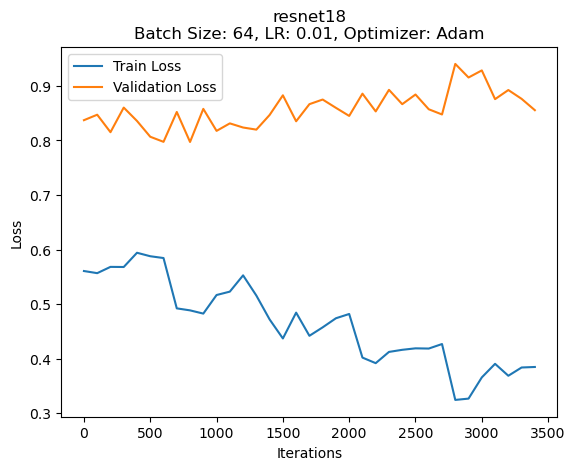

In [25]:
# Define Parameters
num_epochs = 5
input_size = 196608
num_classes = 10
lr = 0.01

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

# Train Model
acc_arr_train, acc_arr_valid, loss_avg_train, loss_avg_valid = train(resnet18, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(loss_avg_train, loss_avg_valid, "resnet18\nBatch Size: 64, LR: 0.01, Optimizer: Adam")

# Evaluate on Test Set
test_accuracy(model=resnet18, test_loader=test_loader, input_size=input_size, loss_fn = loss_function, device=device)

## 5) Confusion Matrix

Write code to plot a confusion matrix after training the above ResNet18. Please make sure the axis have class names (defined in Section 1)

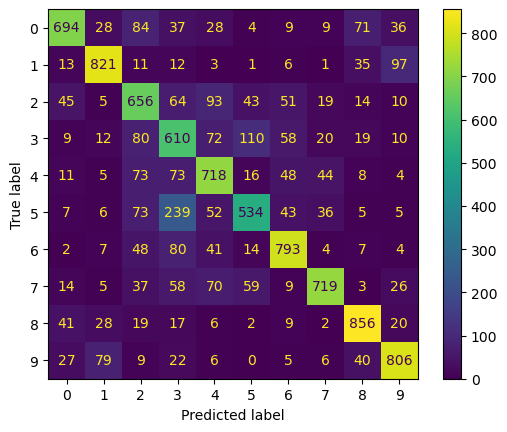

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def calculate_confusion_matrix(model, data_loader, num_classes):
    all_predictions = []
    all_targets = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_targets, all_predictions

# Calculate the confusion matrix
true_labels, predicted_labels = calculate_confusion_matrix(resnet18, test_loader, classes)

# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)


disp = ConfusionMatrixDisplay(confusion_mat)
disp.plot()


## 6) Freeze Network

### 6.1) Initialize a new ResNEt18, Freeze the model weights except last layer, modify the last layer so we only train the last layer.

In [10]:
# Instantiate Pretrained ResNet18
resnet18_frz = models.resnet18(pretrained = True)

# Freeze all layers (except last)
# Freeze everything:
for param in resnet18_frz.parameters():
    param.requires_grad = False
    
# Unfreeze parameters of the last layer
for param in resnet18_frz.fc.parameters():
    param.requires_grad = True

# Modify final layer
resnet18_frz.fc = nn.Linear(resnet18_frz.fc.in_features, num_classes)

# Load onto GPU
device_frz = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet18_frz.to(device)

# View Model to validate
print(resnet18_frz)

/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 6.2) Retrain the frozen ResNet18 now with the same setup as the previous ResNEt18 (same batch size, optimizer, learning rate, etc.)

Epoch [1/5], Step [100/781], Train Loss: 1.9621, Val Loss: 1.9483
Epoch [1/5], Step [200/781], Train Loss: 2.1256, Val Loss: 1.8772
Epoch [1/5], Step [300/781], Train Loss: 2.5730, Val Loss: 1.9076
Epoch [1/5], Step [400/781], Train Loss: 2.1917, Val Loss: 2.1309
Epoch [1/5], Step [500/781], Train Loss: 2.1306, Val Loss: 1.7977
Epoch [1/5], Step [600/781], Train Loss: 2.2663, Val Loss: 1.6346
Epoch [1/5], Step [700/781], Train Loss: 2.7154, Val Loss: 2.2468
Epoch [1/5], Time Taken: 31.3773, Train Acc: 41.3260, Valid Acc: 40.1600
--------------------------------------------------------------
Epoch [2/5], Step [100/781], Train Loss: 2.1503, Val Loss: 2.1001
Epoch [2/5], Step [200/781], Train Loss: 1.9740, Val Loss: 1.9167
Epoch [2/5], Step [300/781], Train Loss: 2.3918, Val Loss: 1.7703
Epoch [2/5], Step [400/781], Train Loss: 1.8807, Val Loss: 1.8808
Epoch [2/5], Step [500/781], Train Loss: 1.7341, Val Loss: 2.2674
Epoch [2/5], Step [600/781], Train Loss: 1.8651, Val Loss: 2.3606
Epoch 

34.34

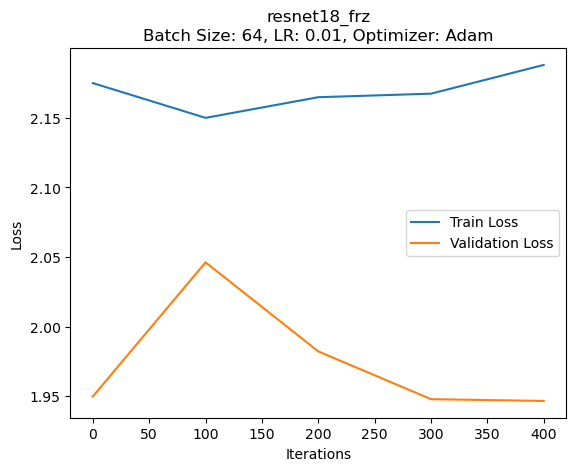

In [12]:
# Define Parameters
num_epochs = 5
input_size = 196608
num_classes = 10
lr = 0.01

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_frz.parameters(), lr=lr)

# Train Model
acc_arr_train, acc_arr_valid, loss_avg_train, loss_avg_valid = train(resnet18_frz, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(loss_avg_train, loss_avg_valid, "resnet18_frz\nBatch Size: 64, LR: 0.01, Optimizer: Adam")

# Evaluate on Test Set
test_accuracy(model = resnet18_frz, test_loader = test_loader, input_size = input_size, device = device)

## 6.3) Confusion Matrix (Frozen)

Use the same code as section 5, but now plot the confusion matrix for the results of the frozen network.

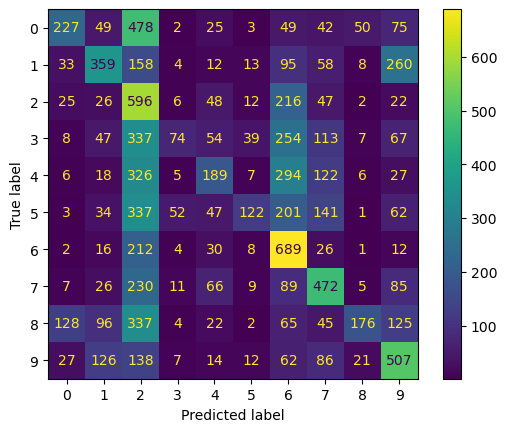

In [13]:
# Calculate the confusion matrix
true_labels_frz, predicted_labels_frz = calculate_confusion_matrix(resnet18_frz, test_loader, classes)

# Compute the confusion matrix
confusion_mat_frz = confusion_matrix(true_labels_frz, predicted_labels_frz)


disp = ConfusionMatrixDisplay(confusion_mat_frz)
disp.plot()

## 7) Reporting

Please answer the following questions based on the training and learning curves from the previous sections.

#### Q 7.1) What is transfer learning and why would it be useful?

#### Q 7.2) What (if any) modifications to the pretrained model would you need to do and why?

#### Q 7.3) Why would you retrain from a pretrained network? What is advantage of not re-initalizing the pre-trained network.

#### Q 7.4) Please explain precision and recall.

#### Q 7.5) Explain what a confusion matrix is. Use your output confusion matrix as an example.

#### Q 7.6) What was the difference between freezing layers and retraining all? Explain in terms of classification metrics and why you saw such metrics and confusuon matrix. Is what you say as expected?

#### Q 7.7) For a pretrained model like ResNet, in what general scenarios would you (1) freeze your pretrained weights adn retrain last layer, (2) retrain entire architecture, and (3) Freeze all convolution layer weights and retrain all FC layers? Explain with example scenarios if possible.

7.1) transfer learning is when you use a model trained by someone else and add a some layers on top or change the number of outputs to apply it to a different scenario. It is useful because it saves a lot of training time by using a model that is pretrained. These models are usually trained on large amounts of data so have good generalization.

7.2) You need to change the number of outputs to match the situation the model is being applied to and can also add some layers if the task is different enough or if the number of outputs is drastically different.

7.3) Not re-initializing gives the model a good starting point for parameters so that it converges much faster since it is already close to an optimized loss value from the previous training. Retraining could be useful if the application is different from the pretrained model so that it can adapt to the new situation it is applied to.

7.4) Precision is how many of the predictions made for a class by the model are actually correct. It is calculated by the number of true predictions of the class divided by the total number of predictions made for the class. Recall is the ratio of how many times the model correctly classifies a class divided by how many times the class appears in the dataset.

7.5) A confusion matrix shows what class the model predicted an input to be vs what the actual input is labeled. Everything along the diagonal is a correct prediction since the predicted label and the actual label match. Anything off the diagonal is an incorrect prediction since the actual label is different from what the model predicted.

7.6) Freezing layers led to much higher loss and lower accuracy but prevented overfitting since it didn't retrain the parameters in the original resnet model and only the new layer we added. Retraining the entire model increases the performance metrics but overfits the data as the validation loss increases at a certain point because changing the entire model based on the dataset removes some of the generality that the pretrained model had on its original training.

7.7) 

1) We would freeze our pretrained weights and retrain the last layer in the event where we had a small dataset to work with. This should perform better since there will be less overfitting, which would occur if we attempted to tune our entire model. An example of this would be image classification with a small dataset.

2) We would retrain the entire architecture if we had a large, expansive data set to work with, or if the new task differed from what the original model (resnet 18) was pre-trained to. An example would be using the resnet model for object detection instead of image classification.

3) The convolution layer weights learn the feature representations from the input data, which typically can be applied across different tasks. FC layers, however, contain information specific to the current task, so they need to be retrained to fit the new task at hand. You would use the approach when applying the network to a different task. An example would be if you initially trained the model to classify animals, but now wanted to use the model to classify specfic species of birds. Since animals should share some similar features, we need to adapt the model to this task, so we freeze the convolution layer and retrain the FC layers.